# ***Machine Learning Prueba 2 - Analizando los crímenes en la Ciudad de Nueva York***.
### Nombre(s): Thomas Peet, Braulio Águila, Camilo Ramírez
### Generación: G47
### Profesores: Alfonso Tobar - Sebastián Ulloa
### Fecha: 06-10-2022

In [1]:
# Librerías base
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as cx
#import shapely
#import folium 
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import sys
sys.path.append('..')
from pathlib import Path

# Herramientas base
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Imb_Pipeline

# Transformers importados
from sklearn.preprocessing import FunctionTransformer
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Transformers customizados
import utils
from utils import CreateSuitableDataframeTransformer
from utils import OrdinalEncoderFixedTransformer
from utils import DropRowsTransformer
from utils import PrintVars

# Estimators importados desde librerías
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import StackingClassifier

# Estimators customizados
from utils import KerasCustomClassifier

from sklearn import set_config
set_config(display='diagram')

---
# Lectura de Dataset interrogaciones/detenciones Policía de Nueva York - 2009***:

In [2]:
df2009 = pd.read_csv('2009_1perc.csv', index_col=0)
df2009.shape

(5812, 111)

---
# Limpieza del dataset

Esta transformación (se serializa para ser aplicada también en testing) aplica los siguientes criterios para descartar datos
- Datos sin xcoord/ycoord
- Registros de menores de 18 años

In [4]:
drt = DropRowsTransformer()
df2009_nonull = drt.transform(df2009)

---
# Definición de los 2 problemas

La función `split_features_target` segmenta el dataframe en 2 problemas: clasificación de arrestos y clasificación de arrestos con violencia.

En esta exploración se definirá la variable y_1 como la columna 'arstmade' y la variable y_2 como una construcción a partir de las siguientes columnas:

In [20]:
var_eliminar_pf = ["pf_baton", "pf_hcuff", "pf_pepsp", "pf_other", "pf_ptwep", "pf_drwep", "pf_wall", "pf_hands", "pf_grnd"]

La manera en que se construirá y_2 a partir de estas variables es a través una función AND entre todas ellas.

En consecuencia estas variables se eliminan de la matriz de predictores del segundo problema.

In [21]:
x_1, y_1, x_2, y_2 = utils.split_features_target(df2009_nonull, var_eliminar_pf)
x_1.shape, y_1.shape, x_2.shape, y_2.shape

((4499, 111), (4499,), (4499, 103), (4499,))

---
# Exploración de los datasets

¿Qué tan categóricas son las variables? ¿ Si una variable se dice que es categórica, pero tiene casi tantas clases como datos, es correcto seguir considerandola como categórica?

In [ ]:
utils.cat_num_rate_analysis(df2009_nonull)


### Análisis de distribución de targets

Exploración de variable arstmade y variable violence

In [ ]:
#Visualización de el vector objetivo:
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(y_1); # Categoría uno muchos menos casos que categoría 0.
plt.title("Vector objetivo : arstmade")
plt.xlabel("clases");
plt.subplot(1,2,2)
sns.histplot(y_2);
plt.title("Vector objetivo : violence")
plt.xlabel("clases");

### Análisis de correlación de los datos

Analisis de correlación para feature selection: Encodeamos los datos para poder calcular la matriz de correlación e identificar las variables que eliminaremos por tener una correlación superior a 0.6 

In [16]:
oe = OrdinalEncoderFixedTransformer(encoding_method='ordered')
df2009_nonull_tr = oe.fit_transform(df2009_nonull.drop(columns = 'arstmade'), y_1)
utils.get_top_correlations_blog(df2009_nonull_tr, threshold=0.6)

,,Correlation Coefficient
Variable 1,Variable 2,
addrpct,pct,1.000000
age_individual,age,1.000000
repcmd,revcmd,0.991459
offunif,offshld,0.991262
sumissue,sumoffen,0.860100
offunif,offverb,0.837786
offverb,offshld,0.828391
ht_feet,ht_inch,-0.771073
rf_furt,frisked,0.706808


In [17]:
var_eliminar_por_corr = ["addrpct", "age_individual","repcmd", "sumissue","ht_feet", "searched", "offunif", "offverb", "frisked", "rf_bulg"] 

### Definición de columnas a eliminar en base a "Criterios Expertos"

Considerar variables relevantes para modelos de procedimiento que concluye en arresto y/o procedimiento que concluye en situación violenta:

In [ ]:

var_eliminar_others = ["ac_rept", "ac_inves", "ac_proxm", "cs_casng", "cs_lkout", "explnstp","sumissue", "offunif", "officrid", "frisked", "cs_cloth", "offverb", "rf_furt", "ac_other", "rf_bulg", "cs_furtv", "recstat", "cs_bulge", "cs_other", "trhsloc", "build", "beat", "post","rf_attir", "cs_objcs","eyecolor", "haircolr", "sector" ]

### Análisis y gráficos de probabilidades condicionales

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'violence')

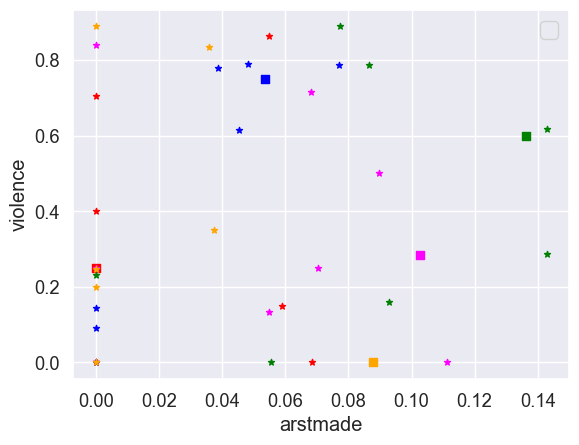

In [23]:
# pd.set_option('display.max_rows', None)
df_probs = df2009_nonull.copy()
var_pf = df_probs.columns[np.where([i[0:2]=='pf' for i in df_probs.columns.tolist()])].tolist()
serie = pd.Series([int(np.isin(["Y"], df_probs[var_pf].iloc[i].values.tolist())[0]) for i in range(0, len(df_probs[var_pf]))], index = df_probs.index)
df_probs['violence'] = serie

probs = pd.DataFrame(df_probs.groupby(['city', 'race', 'sex']).arstmade.value_counts
(normalize=True))
counts = pd.DataFrame(df_probs.groupby(['city', 'race', 'sex']).arstmade.value_counts
(normalize=False))

probs_v = pd.DataFrame(df_probs.groupby(['city', 'race', 'sex']).violence.value_counts
(normalize=True))
counts_v = pd.DataFrame(df_probs.groupby(['city', 'race', 'sex']).violence.value_counts
(normalize=False))

# Sex: F, M, Z
# Race: A, B, I, P, Q, U, W, X, Z
# City: BRONX, QUEENS, STATEN ISLAND, MANHATTAN, BROOKLYN

zprobs = list(zip(probs['arstmade'], probs_v['violence'], probs.index))
for x, y, i in zprobs:
    # display(i)
    if i[3] == 'N':
        if i[2] == 'M':
            if i[0] == 'BRONX':
                c = 'red'
            elif i[0] == 'BROOKLYN':
                c = 'blue'
            elif i[0] == 'MANHATTAN':
                c = 'green'
            elif i[0] == 'QUEENS':
                c = 'magenta'
            else:
                c = 'orange'
            
            if i[1] == 'W':
                m = 's'
                s = 40
            else:
                m = '*'
                s = 20
            # elif 

        
            plt.scatter(1-x,1-y, c= c, marker=m, s=s)
plt.legend(loc='best', fontsize=16)
plt.xlabel('arstmade')
plt.ylabel('violence')


# print(probs.query("race == 'B' & sex == 'M' "))
# print(probs.query("race == 'W' & sex == 'M' "))
# print('--------------')
# print(probs_v.query("race == 'B' & sex == 'M' "))
# print(probs_v.query("race == 'W' & sex == 'M' "))

Comentarios de las probabilidades

---
### Gráficos georeferenciados de arrestos y violencia

In [ ]:
'''
gdf = gpd.GeoDataFrame(df2009_nonull, geometry=gpd.points_from_xy(df2009_nonull.xcoord, df2009_nonull.ycoord))

df = gpd.read_file(gpd.datasets.get_path("nybb"))
df_wm = df.to_crs(epsg=3857)

ax = df.plot(figsize=(15,10), alpha=0.5, edgecolor = "k")
cx.add_basemap(ax,crs=df.crs, zoom =11, source=cx.providers.Stamen.TonerLite)
#cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
gdf.plot(ax=ax, color= "red", edgecolor = "black", markersize = 4)


#Incorporar al código de arriba para poder plotear variable objetivo:
# fig,ax = plt.subplots(1, 1) #plt.figure(figsize=(10,8))
# fig.set_size_inches(25, 25)
# df2009map[df2009map.arstmade == "N"].plot(color="red", ax=ax, markersize = 1)
# df2009map[df2009map.arstmade == "Y"].plot(ax=ax,  markersize = 12)
# plt.show()
# función transformar x,y to lon, lat:
def xy_to_latlon(x,y):
    source_crs = 'epsg:2263' # Coordinate system of the file
    target_crs = 'epsg:4326' # Global lat-lon coordinate system
    polar_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)
    lat, lon = polar_to_latlon.transform(x,y)
    return lon, lat
df_shape_ny = gpd.read_file(gpd.datasets.get_path("nybb")).to_crs(epsg=3857)
df_shape_ny

import folium
m = folium.Map(location=[40.7127837, -74.0059413],control_scale=True, zoom_start=10,tiles='CartoDB positron')
# base_map.add_to(f)
for _, r in df_shape_ny.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j)
    # folium.Popup(r['BoroName']).add_to(geo_j)
    geo_j.add_to(m)
m
geometrias = [list(x.exterior.coords) for x in df_shape_ny.geometry[0]] 
from scipy.spatial import ConvexHull
from folium import plugins
import folium

f = folium.Figure(width=700, height=400)    
base_map = folium.Map(location=[40.7127837, -74.0059413],control_scale=True, zoom_start=10,tiles='CartoDB positron')
base_map.add_to(f)

# folium.GeoJson(data=df_shape_ny["geometry"]).add_to(base_map)

colors = ['orange','yellow','red','blue','green']

for _, r in df_shape_ny.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry'])
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,  style_function=lambda x: {'fillColor': 'orange'})
    # folium.Popup(r['BoroName']).add_to(geo_j)
    geo_j.add_to(base_map)


# for point,color in zip(df_shape_ny["geometry"],colors):
# 	# if color == 'orange' or True:
# 		# lats, longs = xy_to_latlon([i[0] for i in point],[i[1] for i in point], polar_to_latlon)
# 		# positions = [(y, x) for x, y in zip(lats, longs)]
# 		# points_rev = [(y,x) for x,y in point]
# 		# points_rev = [points_rev[i] for i in ConvexHull(points_rev).vertices]
# 		# if color == 'orange':
# 			# display(positions)
# 	# sim_geo = gpd.GeoSeries(point).simplify(tolerance=0.001)
# 	# geo_j = sim_geo.to_json()
# 	# rrr = gpd.GeoSeries(point).simplify(tolerance=0.001).to_json()
# 	folium.GeoJson(data=pd.Series(point),  style_function=lambda feature: {
#             'fillColor': color,
#             'fillOpacity': 0.8,
#         }).add_to(base_map)
	# geo_j = folium.GeoJson(data=geo_j,  style_function=lambda x: {'fillColor': 'orange'})
	# folium.Popup(r['BoroName']).add_to(geo_j)
	# geo_j.add_to(base_map)

	# plugins.PolyLineOffset(locations=point, color='blue', fill=True, fill_color=color, fill_opacity=0.5, smooth_factor=.1).add_to(base_map)

# lats, longs = xy_to_latlon(df2009.xcoord.to_list(), df2009.ycoord.to_list(), xy_to_latlon)
# for lat, lon, i in zip(lats, longs, df2009.arstmade):
#     color = 'blue' if i == 'Y' else '#FF000030'
#     size = '20' if i == 'Y' else '10'
#     border = 'none' if i == 'Y' else 'none'
#     folium.Marker(location=[str(lon), str(lat)], icon=folium.DivIcon(html=f"<span style='font-size:{size}px;color:{color};border:{border}'>&#9670;</span>"),popup=i).add_to(base_map)
base_map
#otra opción de crear mapa con folium:
import folium
def generateBaseMap(loc, zoom=11, tiles='OpenStreetMap', crs='ESPG3857'):
    return folium.Map(location=loc,
                   #control_scale=True, 
                   zoom_start=zoom,
                   #tiles=tiles)
    )
base_map = generateBaseMap([40.7127837, -74.0059413])


marker = list(range(len(df2009.xcoord)))
counter = 0
tooltip = "Click Here For More Info"
icon = folium.features.CustomIcon('https://cdn-icons-png.flaticon.com/128/7500/7500224.png', icon_size=(40, 40))

for x,y in zip(df2009.xcoord, df2009.ycoord):
    lon, lat = xy_to_latlon(x,y)
    marker[counter] = folium.Marker(icon=icon,
    #     #location=[40.7127837, -74.0059413],
    location=[lon, lat],
    #     #popup="<stong>Allianz Arena</stong>",
    #     #tooltip=tooltip
    )
    marker[counter].add_to(base_map)
    #print(f"latitud {lat} y longitud {lon}")
    if counter>5 : 
        break
    counter += 1
base_map
'''

Comentarios de los gráficos

---
# Problemas de clasificación
### Definición de Clasificadores Base

In [24]:
# Clasificadores base
gnb     = GaussianNB()
knc     = KNeighborsClassifier()
svc     = SVC(random_state=42, probability=True)
gbc     = GradientBoostingClassifier(random_state=42)
lr      = LogisticRegression(random_state=42, C=0.01)
rfc     = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)

# metaestimator stacking
sc_1 = StackingClassifier(estimators=[("lr", lr), ("rfc", rfc)], final_estimator=gbc, cv=5)
# En este caso se eligieron clasificadores de naturaleza distinta en los estimadores. En el final estimator se selecciono un gradient boosting.

# metaestimator voting
vc_1 = VotingClassifier([("lr", lr), ("knc", knc), ("gbc", gbc)], voting="hard", n_jobs=-1)
# Se eligio un número impar de modelos para que siempre exista mayoría. 

# metaestimator boosting
bc_1 = AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=1, n_estimators=5), random_state=42, n_estimators=100, learning_rate=1)

nn_arch = {
    'input_layer'       : ('input_dense', 32, 'relu'),
    'drop_1'            : ('dropout', .2),
    'output_layer'      : ('dense', 1, 'sigmoid')
}

# Red neuronal
kcc = KerasCustomClassifier(    
                                nn_arch, 
                                loss='binary_crossentropy',
                                optimizer='Adam',
                                metrics='accuracy',
                                net_name='twitter_keras_net',
                                epochs=10
                            )

### Definición del main pipeline dependiendo de la métrica a optimizar y del problema

In [ ]:

# Solución para usar SMOTE en gridsearch con muchos pasos: https://stackoverflow.com/questions/65652054/not-able-to-feed-the-combined-smote-randomundersampler-pipeline-into-the-main


def main_pipeline(estimator, type='accuracy', problema='arstmade'):
    if problema == 'arstmade':
        if type=='accuracy':
            return Imb_Pipeline(steps=[
                ('ce', FunctionTransformer(utils.criterio_experto, kw_args={'columns': var_eliminar_por_corr + var_eliminar_pf})),
                ('csd', CreateSuitableDataframeTransformer()),
                ('cat_imp', CategoricalImputer(imputation_method='frequent')),
                ('oe', OrdinalEncoderFixedTransformer(encoding_method='ordered')),# aqui estoy pasando info desde el proceso csd (que son las columnas que seleccionamos como categoricas) para encodear.
                ('num_imp', MeanMedianImputer(imputation_method='median')),
                ('sc', SklearnTransformerWrapper(StandardScaler())),
                ('model', estimator)
            ])
        
        return Imb_Pipeline(steps=[
            ('csd', CreateSuitableDataframeTransformer()),
            ('cat_imp', CategoricalImputer(imputation_method='frequent')),
            ('oe', OrdinalEncoderFixedTransformer(encoding_method='ordered')),
            ('num_imp', MeanMedianImputer(imputation_method='median')),
            ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
            ('sc', SklearnTransformerWrapper(StandardScaler())),
            ('model', estimator)
        ])
    return Imb_Pipeline(steps=[
        ('csd', CreateSuitableDataframeTransformer()),
        ('cat_imp', CategoricalImputer(imputation_method='frequent')),
        ('oe', OrdinalEncoderFixedTransformer(encoding_method='arbitrary')),
        ('num_imp', MeanMedianImputer(imputation_method='median')),
        ('sc', SklearnTransformerWrapper(StandardScaler())),
        ('model', estimator)
    ])

def gridsearch_train_and_save(pipe,x,y, params, scoring='accuracy', file_name='file.pickle'):
    search = GridSearchCV(pipe, params, cv=5, scoring=scoring, n_jobs=4, error_score='raise', verbose=10)
    search.fit(x, y)
    utils.save_bytes_variable({'best_params': search.best_params_, 'best_score': search.best_score_, 'results': pd.DataFrame(search.cv_results_), 'params': params}, file_name)
    return search

Se fijaron parámetros del preprocesamiento en función de un gridsearch que se corrió con un estimador modelo (Random Forest) que permitiera encontrar los parámetros óptimos de esta etapa para luego poder centrarnos solo en refinar los parámetros del modelo elegido.

---
# Procedimiento que termina en arresto `(Arstmade)`
### Optimización del sub-pipeline de preprocessing del problema y_1 (accuracy y recall)

In [ ]:
l1 = list(set(var_eliminar_por_corr + var_eliminar_others + var_eliminar_pf))
l2 = list(set(var_eliminar_por_corr + var_eliminar_pf))
l3 = list(set(var_eliminar_por_corr + var_eliminar_others))
params = {
        'ce': [     
                FunctionTransformer(utils.criterio_experto, kw_args={'columns':l1}),
                FunctionTransformer(utils.criterio_experto, kw_args={'columns':l2}),
                FunctionTransformer(utils.criterio_experto, kw_args={'columns':l3}),
                FunctionTransformer(utils.criterio_experto, kw_args={'columns':[]}),        
                ],
        # 'smote': [SMOTE(sampling_strategy='auto',random_state=42), None],
        'cat_imp__imputation_method': ['frequent', 'missing'],
        'num_imp__imputation_method': ['median', 'mean'],
        'oe__encoding_method': ['ordered', 'arbitrary']
}

pipe1 = main_pipeline(rfc)
pipe2 = main_pipeline(rfc)

search_acc = gridsearch_train_and_save(pipe1,x_1,y_1, params, scoring='accuracy', file_name='gridsearch_preprocessing_crimenes_accuracy.pickle')
search_rec = gridsearch_train_and_save(pipe2,x_1,y_1, params, scoring='recall', file_name='gridsearch_preprocessing_crimenes_recall.pickle')

In [ ]:
search_acc.best_params_, search_acc.best_score_

In [ ]:
search_rec.best_params_, search_rec.best_score_

### Evaluación de modelos en accuracy

#### GridSearch de Modelo 1: Stacking

In [ ]:
pipe_stacking = main_pipeline(sc_1)

params_stacking = {
    'model__final_estimator__n_estimators': [50, 100, 500],
    'model__final_estimator__max_depth': [5, 10, 50]
}

search_stacking = gridsearch_train_and_save(pipe_stacking,x_1,y_1, params_stacking, scoring='accuracy', file_name='gridsearch_stacking_crimenes_accuracy.pickle')


#### GridSearch de Modelo 2: Voting

In [ ]:
pipe_voting = main_pipeline(vc_1)

params_voting = {
                    'model__voting': ['hard','soft']
                }

search_voting = gridsearch_train_and_save(pipe_voting,x_1,y_1, params_voting, scoring='accuracy', file_name='gridsearch_voting_crimenes_accuracy.pickle')

#### GridSearch de Modelo 3: GBoost

In [ ]:
pipe_gboost = main_pipeline(gbc)

params_gboost = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5, 1],
    'model__max_depth': [1, 2, 3, 4, 5]
}

search_gboost = gridsearch_train_and_save(
    pipe_gboost, x_1, y_1, params_gboost, scoring='accuracy', file_name='gridsearch_gboost_crimenes_accuracy.pickle')


#### GridSearch de Modelo 4: Adaboost

In [ ]:
pipe_adaboost = main_pipeline(bc_1)

params_adaboost = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5, 1]
}

search_adaboost = gridsearch_train_and_save(
    pipe_adaboost, x_1, y_1, params_adaboost, scoring='accuracy', file_name='gridsearch_adaboost_crimenes_accuracy.pickle')


#### GridSearch de Modelo 5: Red Neuronal

In [ ]:
pipe_nn = main_pipeline(kcc)

nn_arch_1 = {
    'input_layer': ('input_dense', 32, 'relu'),
    'drop_1': ('dropout', .2),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_2 = {
    'input_layer': ('input_dense', 16, 'relu'),
    'drop_1': ('dropout', .2),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_3 = {
    'input_layer': ('input_dense', 32, 'relu'),
    'drop_1': ('dropout', .1),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_4 = {
    'input_layer': ('input_dense', 16, 'relu'),
    'drop_1': ('dropout', .1),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_5 = {
    'input_layer': ('input_dense', 32, 'relu'),
    'drop_1': ('dropout', .4),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_6 = {
    'input_layer': ('input_dense', 16, 'relu'),
    'drop_1': ('dropout', .4),
    'output_layer': ('dense', 1, 'sigmoid')
}

params_nn = {
    'model__epochs': [5, 10, 20],
    'model__nn_arch': [nn_arch_1, nn_arch_2, nn_arch_3, nn_arch_4, nn_arch_5, nn_arch_6],
}


search_nn = gridsearch_train_and_save(pipe_nn, x_1,y_1, params_nn, scoring='accuracy', file_name='gridsearch_nn_crimenes_accuracy.pickle')


### Evaluación de modelos en recall

#### GridSearch de Modelo 1: Stacking

In [ ]:
pipe_stacking_r = main_pipeline(sc_1, type='recall')

params_stacking_r = {
    'model__final_estimator__n_estimators': [50, 100, 500],
    'model__final_estimator__max_depth': [5, 10, 50]
}

search_stacking_r = gridsearch_train_and_save(pipe_stacking_r,x_1,y_1, params_stacking_r, scoring='recall', file_name='gridsearch_stacking_crimenes_recall.pickle')


#### GridSearch de Modelo 2: Voting

In [ ]:
pipe_voting_r = main_pipeline(vc_1, type='recall')

params_voting_r = {
                    'model__voting': ['hard','soft']
                }

search_voting_r = gridsearch_train_and_save(pipe_voting_r,x_1,y_1, params_voting_r, scoring='recall', file_name='gridsearch_voting_crimenes_recall.pickle')

#### GridSearch de Modelo 3: GBoost

In [ ]:
pipe_gboost_r = main_pipeline(gbc, type='recall')

params_gboost_r = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5, 1],
    'model__max_depth': [1, 2, 3, 4, 5]
}

search_gboost_r = gridsearch_train_and_save(
    pipe_gboost_r, x_1, y_1, params_gboost_r, scoring='recall', file_name='gridsearch_gboost_crimenes_recall.pickle')


#### GridSearch de Modelo 4: Adaboost

In [ ]:
pipe_adaboost_r = main_pipeline(bc_1, type='recall')

params_adaboost_r = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5, 1]
}

search_adaboost_r = gridsearch_train_and_save(
    pipe_adaboost_r, x_1, y_1, params_adaboost_r, scoring='recall', file_name='gridsearch_adaboost_crimenes_recall.pickle')


#### GridSearch de Modelo 5: Red Neuronal

In [ ]:
pipe_nn_r = main_pipeline(kcc, type='recall')

nn_arch_1 = {
    'input_layer': ('input_dense', 32, 'relu'),
    'drop_1': ('dropout', .2),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_2 = {
    'input_layer': ('input_dense', 16, 'relu'),
    'drop_1': ('dropout', .2),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_3 = {
    'input_layer': ('input_dense', 32, 'relu'),
    'drop_1': ('dropout', .1),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_4 = {
    'input_layer': ('input_dense', 16, 'relu'),
    'drop_1': ('dropout', .1),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_5 = {
    'input_layer': ('input_dense', 32, 'relu'),
    'drop_1': ('dropout', .4),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_6 = {
    'input_layer': ('input_dense', 16, 'relu'),
    'drop_1': ('dropout', .4),
    'output_layer': ('dense', 1, 'sigmoid')
}

params_nn_r = {
    'model__epochs': [5, 10, 20],
    'model__nn_arch': [nn_arch_1, nn_arch_2, nn_arch_3, nn_arch_4, nn_arch_5, nn_arch_6],
}


search_nn_r = gridsearch_train_and_save(pipe_nn_r, x_1,y_1, params_nn_r, scoring='recall', file_name='gridsearch_nn_crimenes_recall.pickle')


---
# Procedimiento con violencia `(Violence)`
### Optimización del sub-pipeline de preprocessing del problema y_2 (accuracy)

In [ ]:
l1 = list(set(var_eliminar_por_corr + var_eliminar_others + var_eliminar_pf))
l2 = list(set(var_eliminar_por_corr + var_eliminar_pf))
l3 = list(set(var_eliminar_por_corr + var_eliminar_others))
params = {
        'ce': [     
                FunctionTransformer(utils.criterio_experto, kw_args={'columns':l1}),
                FunctionTransformer(utils.criterio_experto, kw_args={'columns':l2}),
                FunctionTransformer(utils.criterio_experto, kw_args={'columns':l3}),
                FunctionTransformer(utils.criterio_experto, kw_args={'columns':[]}),        
                ],
        'smote': [SMOTE(sampling_strategy='auto',random_state=42), None],
        'cat_imp__imputation_method': ['frequent', 'missing'],
        'num_imp__imputation_method': ['median', 'mean'],
        'oe__encoding_method': ['ordered', 'arbitrary']
}

pipe1_v = main_pipeline(rfc, problema='violence')
pipe2_v = main_pipeline(rfc, problema='violence')

search_acc_v = gridsearch_train_and_save(pipe1_v, x_2, y_2, params, scoring='accuracy', file_name='gridsearch_preprocessing_crimenes_violence_accuracy.pickle')

### Evaluación de modelos en accuracy
#### GridSearch de Modelo 1: Stacking

In [ ]:
pipe_stacking_v = main_pipeline(sc_1, problema='violence')

params_stacking_v = {
    'model__final_estimator__n_estimators': [50, 100, 500],
    'model__final_estimator__max_depth': [5, 10, 50]
}

search_stacking_v = gridsearch_train_and_save(
    pipe_stacking_v,x_2, y_2, params_stacking_v, scoring='accuracy', file_name='gridsearch_stacking_crimenes_violence_accuracy.pickle')


#### GridSearch de Modelo 2: Voting

In [ ]:
pipe_voting_v = main_pipeline(vc_1, problema='violence')

params_voting_v = {
                    'model__voting': ['hard','soft']
                }

search_voting_v = gridsearch_train_and_save(
    pipe_voting_v, x_2, y_2, params_voting_v, scoring='accuracy', file_name='gridsearch_voting_crimenes_violence_accuracy.pickle')


#### GridSearch de Modelo 3: GBoost

In [ ]:
pipe_gboost_v = main_pipeline(gbc, problema='violence')

params_gboost_v = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5, 1],
    'model__max_depth': [1, 2, 3, 4, 5]
}

search_gboost_v = gridsearch_train_and_save(pipe_gboost_v, x_2, y_2, params_gboost_v, scoring='accuracy', file_name='gridsearch_gboost_crimenes_violence_accuracy.pickle')


#### GridSearch de Modelo 4: Adaboost

In [ ]:
pipe_adaboost_v = main_pipeline(bc_1, problema='violence')

params_adaboost_v = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.5, 1]
}

search_adaboost_v = gridsearch_train_and_save(pipe_adaboost_v, x_2, y_2, params_adaboost_v,
                                            scoring='accuracy', file_name='gridsearch_adaboost_crimenes_violence_accuracy.pickle')


#### GridSearch de Modelo 5: Red Neuronal

In [ ]:
pipe_nn_v = main_pipeline(kcc, problema='violence')

nn_arch_1 = {
    'input_layer': ('input_dense', 32, 'relu'),
    'drop_1': ('dropout', .2),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_2 = {
    'input_layer': ('input_dense', 16, 'relu'),
    'drop_1': ('dropout', .2),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_3 = {
    'input_layer': ('input_dense', 32, 'relu'),
    'drop_1': ('dropout', .1),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_4 = {
    'input_layer': ('input_dense', 16, 'relu'),
    'drop_1': ('dropout', .1),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_5 = {
    'input_layer': ('input_dense', 32, 'relu'),
    'drop_1': ('dropout', .4),
    'output_layer': ('dense', 1, 'sigmoid')
}

nn_arch_6 = {
    'input_layer': ('input_dense', 16, 'relu'),
    'drop_1': ('dropout', .4),
    'output_layer': ('dense', 1, 'sigmoid')
}

params_nn_v = {
    'model__epochs': [5, 10, 20],
    'model__nn_arch': [nn_arch_1, nn_arch_2, nn_arch_3, nn_arch_4, nn_arch_5, nn_arch_6],
}


search_nn_v = gridsearch_train_and_save(
    pipe_nn_v, x_2, y_2, params_nn_v, scoring='accuracy', file_name='gridsearch_nn_crimenes_violence_accuracy.pickle')


---
# Resultados obtenidos

In [25]:
print('Comparación por ACCURACY')
for file in glob.glob("*crimenes_accuracy*"):
    if 'preprocessing' not in file:
        dct = utils.load_bytes_variable(file)
        print(f'{dct["best_score"]} - {file}')


Comparación por ACCURACY
0.963103448275862 - gridsearch_adaboost_crimenes_accuracy.pickle
0.9673259176863181 - gridsearch_gboost_crimenes_accuracy.pickle
0.9659920899765171 - gridsearch_nn_crimenes_accuracy.pickle
0.9602123346928686 - gridsearch_stacking_crimenes_accuracy.pickle
0.965769620566061 - gridsearch_voting_crimenes_accuracy.pickle


c:\Users\tomas\.conda\envs\geopandas\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator FunctionTransformer from version 1.1.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [26]:
print('Comparación por RECALL')
for file in glob.glob("*crimenes_recall*"):
    if 'preprocessing' not in file:
        dct = utils.load_bytes_variable(file)
        print(f'{dct["best_score"]} - {file}')

Comparación por RECALL
0.507077922077922 - gridsearch_adaboost_crimenes_recall.pickle
0.6085064935064934 - gridsearch_gboost_crimenes_recall.pickle
0.5620537357379463 - gridsearch_nn_crimenes_recall.pickle
0.5616883116883116 - gridsearch_stacking_crimenes_recall.pickle
0.5361038961038961 - gridsearch_voting_crimenes_recall.pickle


In [27]:
print('Comparación en problema de clasificación de violence por ACCURACY')
for file in glob.glob("*crimenes_violence_accuracy*"):
    if 'preprocessing' not in file:
        dct = utils.load_bytes_variable(file)
        print(f'{dct["best_score"]} - {file}')

Comparación en problema de clasificación de violence por ACCURACY
